# ML classification
- load tokenizers
- tokenize data
- load data, split into train, test
- pick classifier (by running multiple tests)
- predict on test data (to determine the accuracy)
- pick the best vocabulary (tokenizer) to use


https://huggingface.co/transformers/preprocessing.html

## Imports and Paths

In [2]:
# !pip install hpsklearn

In [3]:
import os
import IPython

import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tokenizers import CharBPETokenizer
from tokenizers import ByteLevelBPETokenizer

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics
from keras.preprocessing.sequence import pad_sequences

from yellowbrick.classifier import ROCAUC

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import uniform
from sklearn.linear_model import SGDClassifier

from hpsklearn import HyperoptEstimator

import sys 
sys.path.insert(0, "./../" )
from my_classes import ClassificationMetrics

print(os.getcwd())

RANDOM_STATE = 42

suffix = "2x2"
if suffix == "3x3":
    CATEGORIES = ['exon', 'intergenic','intron']
elif suffix == "2x2":
    CATEGORIES = ['exon', 'other']

WARN: OMP_NUM_THREADS=4 =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely
/home/lieberze/DP/Thesis/02_tokenizery_new_data


In [4]:
RootFolder = "/home/lieberze/DP/Thesis/"

DataFolder = os.path.abspath(os.path.join(RootFolder, '05_model_training/data/512_bp_for_encoding/NEW/'))
# FileToEncode_1M = os.path.abspath(os.path.join(DataFolder, 'All_1M.txt'))
FileToEncode_1M = "/home/lieberze/DP/Thesis/05_model_training/data/512_bp_for_encoding/NEW/2x2_200k_shuffled_train.txt"       

AttemptFolder = os.path.abspath(os.path.join(RootFolder, "02_tokenizery_new_data/"))
EncodedFolder_1M = os.path.abspath(os.path.join(AttemptFolder, "data/sample/Encoding/Encoded_512bp_1M_lines/NEW/"))

FolderName = "All_genomes_sample"
name = "01_CharBPE"
CharBPE = os.path.abspath(os.path.join(AttemptFolder, f'{name}/{FolderName}'))
All_512_BPE = os.path.abspath(os.path.join(CharBPE, 'All_512/'))
name = "02_ByteLevelBPE"
ByteLevelBPE = os.path.abspath(os.path.join(AttemptFolder, f'{name}/{FolderName}'))
All_512_BLBPE = os.path.abspath(os.path.join(ByteLevelBPE, 'All_512/'))

In [5]:
! cat $FileToEncode_1M | cut -f1 | sort | uniq -c

 100000 exon
  50000 intergenic
  50000 intron


## Tokenize Data

In [6]:
from transformers import RobertaTokenizer
def LoadTokenizer(TokenizerPath):
    # vocab = f"{TokenizerPath}/vocab.json"
    # merges = f"{TokenizerPath}/merges.txt"
    # tokenizer = Tokenizer(vocab, merges)    
    tokenizer = RobertaTokenizer.from_pretrained(TokenizerPath)
    return tokenizer

def ModifyPath(TokenizerPath, TokenizerName, FolderForEncoded):
    EncodedPath = TokenizerPath.strip("/").split("/")[-2:]
    EncodedPath = TokenizerName + "/" + "/".join(EncodedPath)
    EncodedPath = os.path.abspath(os.path.join(FolderForEncoded, EncodedPath))
    return EncodedPath

def EncodeFile(TokenizerPath, FileToEncodePath, EncodedFilesPath):
    !mkdir -p {EncodedFilesPath}
    print(EncodedFilesPath)
    Tokenizer = LoadTokenizer(TokenizerPath)
    # unk = 0
    with open(FileToEncodePath, "r") as file_in,\
        open(EncodedFilesPath + f"/encoded_{suffix}.txt", "w") as file_out:
        for Line in file_in:
            LineSplit = Line.strip().split()
            SeqType, Seq = LineSplit[0], LineSplit[-1]
            Encoded = Tokenizer(Seq, max_length=128, padding="max_length", truncation=True) 
            Ids = Encoded.get("input_ids")
            # if "<unk>" in Encoded:
            #      unk += 1
            file_out.write(SeqType + "\t" + str(Ids) + "\n")
    # print(f"There are {unk} unk tokens in this file")

In [7]:
a = "ATCTTGGTAACTACTATTATGGTCCTGTGACACACTTGTCTTGCAACACAGGGGGTTTCTGT"

**Next chunk is commented out since it had to be run only one time.**

The run output showed that there are no \<unk> tokens in any of the loaded files

In [8]:
# VocabSizes = [5000, 15000, 50000]
# FileToEncode = FileToEncode_1M
# FolderForEncoded = EncodedFolder_1M

# TokenizerName = "CharBPE"
# Paths = [All_512_BPE]
# ###Tokenizer = CharBPETokenizer
# for Path in Paths:
#     for Size in VocabSizes:
#         TokenizerPath = f"{Path}/{Size}/"
#         # tkn = LoadTokenizer(TokenizerPath)
#         # print(tkn(a))
#         EncodedPath = ModifyPath(TokenizerPath, TokenizerName, FolderForEncoded)
#         EncodeFile(TokenizerPath, FileToEncode, EncodedPath)
        
# TokenizerName = "ByteLevelBPE"
# Paths = [All_512_BLBPE]
# ###Tokenizer = ByteLevelBPETokenizer
# for Path in Paths:
#     for Size in VocabSizes:
#         TokenizerPath = f"{Path}/{Size}/"
#         # tkn = LoadTokenizer(TokenizerPath)
#         # print(tkn(a))
#         EncodedPath = ModifyPath(TokenizerPath, TokenizerName, FolderForEncoded)
#         EncodeFile(TokenizerPath, FileToEncode, EncodedPath)

Show paths of all the files

In [9]:
Names = ["CharBPE", "ByteLevelBPE"]
BasePairLengths = ["All_512"]
VocabSizes = [5000, 15000, 50000]

Paths = []
for Name in Names:
    for BasePairLength in BasePairLengths:
        for Size in VocabSizes:
            Location = Name + "/" + BasePairLength + "/" + str(Size) + "/"
            EncodedPath = os.path.abspath(os.path.join(EncodedFolder_1M, Location))
            Paths.append(EncodedPath)
            # ! cat {EncodedPath+"/encoded_2x2.txt"} | cut -f1 | sort | uniq -c
            # ! head -1 {EncodedPath+"/encoded_2x2.txt"} | wc 
            print(EncodedPath)

/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/CharBPE/All_512/5000
/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/CharBPE/All_512/15000
/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/CharBPE/All_512/50000
/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/ByteLevelBPE/All_512/5000
/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/ByteLevelBPE/All_512/15000
/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/ByteLevelBPE/All_512/50000


## Pick best model and hyperparameters

In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier


model_grid = {    
    # https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
    RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE): {
            "n_estimators": [150, 200, 400],
            "max_depth": [1, 3, 5, 7, 9],
            "criterion": ["gini", "entropy"],
            "min_samples_split": [0.6, 0.8, 2, 4],
            "min_samples_leaf": [0.4, 1, 2, 4, 10, 15]
        },    
    # https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
    GradientBoostingClassifier(max_features = 'sqrt', subsample = 0.8, random_state=RANDOM_STATE): {
            "min_samples_split": [3000, 4000, 5000, 6000],
            "min_samples_leaf": [50, 100, 150, 200],
            "max_depth": [5, 6, 7, 8]
        },        
    RidgeClassifier(random_state=RANDOM_STATE): {
            "alpha": [1e-3, 1e-2, 1e-1, 1]
        },    
    # # KNN - memory problems
    # # It is advised to use the KNN algorithm for multiclass 
    # # classification if the number of samples of the data is less than 50,000
    # KNeighborsClassifier(n_jobs=-1):{
    #     "n_neighbors": [3, 5, 10, 20, 30],
    #     "leaf_size": [5, 10, 20, 30, 40],
    #     "metric": []
    # },    
    # # https://www.mdelcueto.com/blog/kernel-ridge-regression-tutorial/
    # # TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated.
    # # This could be caused by a segmentation fault while calling the function or by an excessive memory
    # # usage causing the Operating System to kill the worker.
    # KernelRidge(): {
    #     "kernel": ['poly', 'rbf', 'linear'],
    #     "degree": [2,3,4,5],
    #     "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1]
    # }   
}

In [19]:
def LoadData(Path):
    SeqTypes, Ids = [], []
    with open(Path, "r") as file:
        for line in file:
            s, i = line.strip().split("\t")
            i = np.array(i.strip("[]").split(", ")).reshape(-1,1)
            SeqTypes.append(s), Ids.append(i)
            
    # adds 1 (for both algorithms it is the id of the <pad> token, post == at the end
    X = pad_sequences(Ids, value=1, padding='post')
    nsamples, nx, ny = X.shape
    X = X.reshape((nsamples,nx*ny)) # from 3 to 2 dimensions
    y = np.array(SeqTypes)            
    return X, y

def PickBest(BestScores):    
    top_model = sorted(BestScores, key=lambda x: x[0], reverse=True)[0]
    # load model with best params
    validation_score, model, params = top_model
    model.set_params(**params)
    print(model)
    print("validation f1_score (weighted):", validation_score)
    model = model.fit(X_train, y_train)
    return model

def TryClassifiers(model_grid, random_state, X_train, y_train):
    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    BestScores = []
    for clf, grid in model_grid.items():
        model = RandomizedSearchCV(estimator=clf, 
                                   param_distributions=grid,
                                   n_iter=5, 
                                   cv=kf,
                                   verbose=1, 
                                   n_jobs=-1,
                                   random_state=random_state, 
                                   scoring = "f1_weighted",
                                  )
        model.fit(X_train, y_train)     
        best_score = model.best_score_
        best_params = model.best_estimator_.get_params()
        BestScores.append([best_score, clf, best_params])
    return BestScores
      
def FitPredictGetMetrics(model, X_test, y_test, PathToSave, TitleName):
    y_pred = model.predict(X_test)
    
    # metrics 
    # acc_score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
    report = metrics.classification_report(y_test, y_pred, digits=2, output_dict=True, zero_division=0)
    # metrics.plot_confusion_matrix(model, X_test, y_test) 
    
    print("test f1_score (weighted):", f1)
    
    # report table (f1, precision, recall)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_pickle(PathToSave + f"/report_{suffix}.pkl")
    weighted_F1_average = df_report["f1-score"]["weighted avg"]
    print(df_report)
    
    # # confusion matrix
    # plt.figure(figsize=(8, 6))
    # df_cm = pd.DataFrame(cm)
    # df_cm.columns = CATEGORIES # ['exon', 'intergenic','intron'] or ["exon", "other"]
    # df_cm.index = CATEGORIES
    # plt.title('Confusion Matrix, normalized', size=16)
    # sns.heatmap(df_cm, annot=True, cmap='Blues')
    # plt.savefig(PathToSave + f'/confusion_matrix_{suffix}.png', transparent=False, dpi=80, bbox_inches="tight")
    # plt.show()    
    
    CMName = PathToSave + f'/confusion_matrix_{suffix}.png'
    ClassificationMetrics.ConfMatrix(y_test, y_pred, CATEGORIES, TitleName, CMName)
    return weighted_F1_average

from sklearn import metrics
def ROCAUCcurve(model, X_train, y_train, X_test, y_test, PathToSave, title):
    my_title = f"ROC Curves for {title}"
    plt.figure(figsize=[8,6])
    sns.set(font_scale=1.3)       
    if suffix == "2x2":
        pos_label = "exon"
        model.fit(X_train, y_train)
        y = np.array(y_test)
        pred = model.predict_proba(X_test)[:,0] # 0 == exon
        fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=pos_label)
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                           estimator_name=my_title)
        # display.plot()
        plt.title(my_title)
        auc = round(np.trapz(tpr,fpr),2)
        plt.plot(fpr,tpr,label=f"ROC of class {pos_label}, AUC = "+str(auc))
        plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='dotted')
        plt.legend(loc=4)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.xlim([-0.01,1.0])
        plt.ylim([0.00,1.01])
        plt.savefig(PathToSave + f'/ROC_curve_{suffix}.png')
        plt.show()
    else:
        visualizer = ROCAUC(model, classes=CATEGORIES, title=my_title, micro=False, macro=False)
        visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
        visualizer.score(X_test, y_test)        # Evaluate the model on the test data
        visualizer.show(outpath = PathToSave + f'/ROC_curve_{suffix}.png')

In [12]:
# model.predict_proba(X_test)

In [13]:
# ROCAUCcurve(model, X_train, y_train, X_test, y_test, Path, title) 

In [14]:
# from sklearn import metrics
# import numpy as np
# import matplotlib.pyplot as plt

# y_true = # true labels
# y_probas = # predicted results
# fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas, pos_label=0)

# # Print ROC curve
# plt.plot(fpr,tpr)
# plt.show() 

# # Print AUC
# auc = np.trapz(tpr,fpr)
# print('AUC:', auc)

In [15]:
# # https://inblog.in/AUC-ROC-score-and-curve-in-multiclass-classification-problems-2ja4jOHb2X

# #importing all the necessary libraries
# from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
# from sklearn.metrics import roc_curve, roc_auc_score

# # model.fit(X_tr, y_tr)

# # predicting the data
# y_pred_cnb = model.predict(X_te)
# y_prob_pred_cnb = model.predict_proba(X_te)

# #roc auc score
# roc_auc_score(y_te, y_prob_pred_cnb, multi_class='ovo', average='weighted')

In [16]:
# # POSSIBLE METRICS FOR RANDOMIZEDSEARCHCV
# import sklearn.metrics
# sklearn.metrics.SCORERS.keys()

z cross validae leze spise validacni error (Vašata)

balancovaný dataset (zmínit)

ROC krivky, recall, precision, F1, confusion matrix 3x3

pro kazdy soubot natrenovat jiny model

## Load any model

In [17]:
# filename = Path + '/classification_model.sav'

# # load the model from disk
# loaded_model = joblib.load(filename)
# # result = loaded_model.score(X_te, y_te)
# print(loaded_model)

## Results for 150k lines. With ROC curves

# create a binary problem (exon vs rest)

- pro 2x2 je potřeba udělat opět balancovaný dataset. exon:(intron+intergenic) = 1:1

In [ ]:
train_size = 150000
test_size = 50000
measures = []
subs = {
        "exon": "exon", 
        "intron": "other",
        "intergenic": "other"
        }
for Path in Paths:
    print(Path)
    X, y = LoadData(Path + f"/encoded_{suffix}.txt")
    y = [subs.get(item) for item in y]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = RANDOM_STATE)
    
    #smaller_sample
    # X_tr, y_tr =  X_train[:train_size], y_train[:train_size]
    # X_te, y_te = X_test[:test_size], y_test[:test_size]

    BestScores = TryClassifiers(model_grid, RANDOM_STATE, X_train, y_train)
    model = PickBest(BestScores)
    
    # save model
    filename = f'/classification_model_{suffix}.sav'
    joblib.dump(model, Path + filename)
    
    weighted_f1_average_ = FitPredictGetMetrics(model, X_test, y_test, Path)
    measures.append(weighted_f1_average_)
    
    # ROCAUCcurve(model, X_tr, y_tr, X_te, y_te, Path)

## Load saved model
classification_model.sav

In [ ]:
# for Path in Paths:
#     print(Path + "/classification_model.sav")

In [ ]:
# import joblib
# pth = Paths[0]+ "/classification_model.sav"
# mdl = joblib.load(pth)

/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/CharBPE/All_512/5000
GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
test f1_score (weighted): 0.61874406684303
              precision    recall  f1-score      support
exon           0.601518  0.702260  0.647997  24827.00000
other          0.648251  0.541175  0.589893  25173.00000
accuracy       0.621160  0.621160  0.621160      0.62116
macro avg      0.624885  0.621717  0.618945  50000.00000
weighted avg   0.625046  0.621160  0.618744  50000.00000


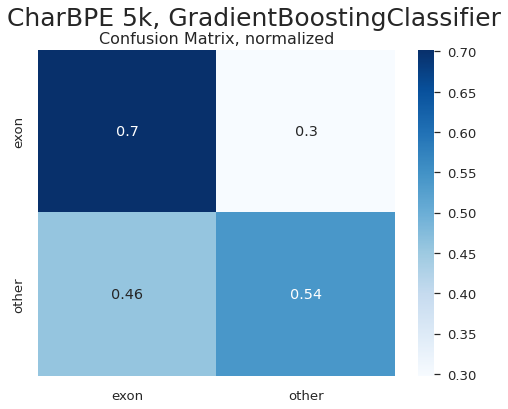

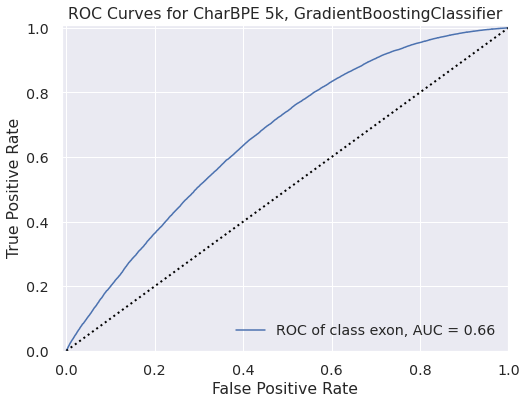

/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/CharBPE/All_512/15000
GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
test f1_score (weighted): 0.601511682991769
              precision    recall  f1-score     support
exon           0.585309  0.702904  0.638739  24827.0000
other          0.634580  0.508839  0.564796  25173.0000
accuracy       0.605200  0.605200  0.605200      0.6052
macro avg      0.609945  0.605871  0.601768  50000.0000
weighted avg   0.610115  0.605200  0.601512  50000.0000


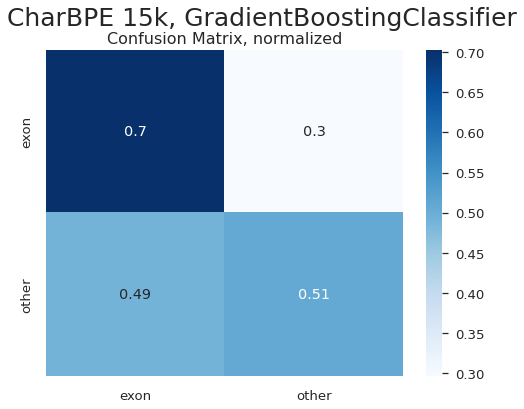

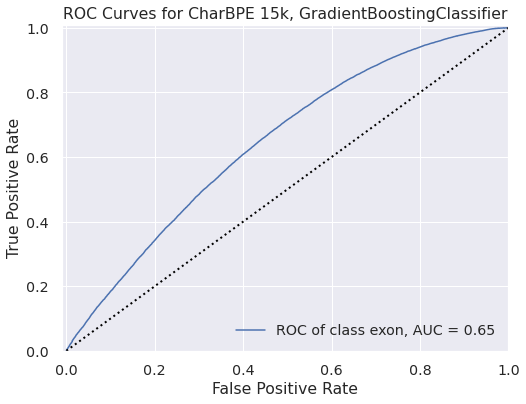

/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/CharBPE/All_512/50000
GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
test f1_score (weighted): 0.5860815832128956
              precision    recall  f1-score      support
exon           0.570606  0.758610  0.651312  24827.00000
other          0.647325  0.436976  0.521747  25173.00000
accuracy       0.596680  0.596680  0.596680      0.59668
macro avg      0.608966  0.597793  0.586530  50000.00000
weighted avg   0.609231  0.596680  0.586082  50000.00000


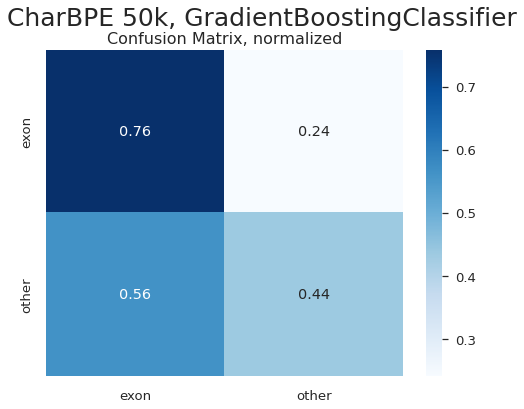

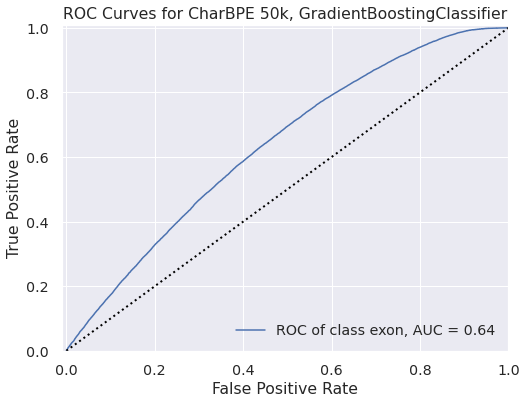

/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/ByteLevelBPE/All_512/5000
GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
test f1_score (weighted): 0.6180448550957657
              precision    recall  f1-score      support
exon           0.600542  0.704918  0.648558  24827.00000
other          0.648768  0.537560  0.587952  25173.00000
accuracy       0.620660  0.620660  0.620660      0.62066
macro avg      0.624655  0.621239  0.618255  50000.00000
weighted avg   0.624822  0.620660  0.618045  50000.00000


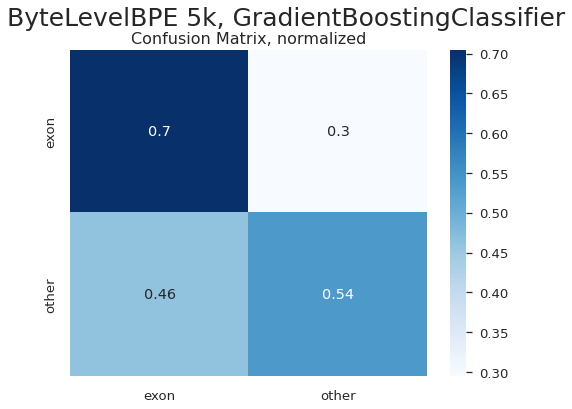

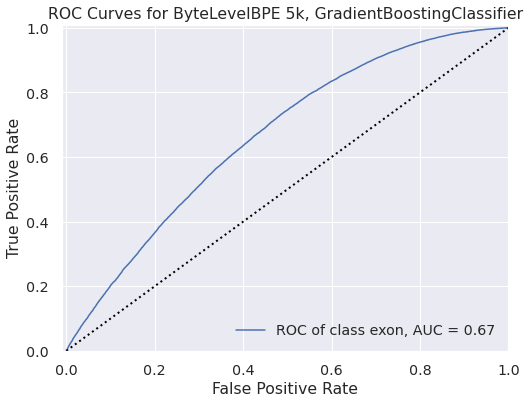

/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/ByteLevelBPE/All_512/15000
GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
test f1_score (weighted): 0.6048964382735007
              precision    recall  f1-score      support
exon           0.587899  0.709188  0.642873  24827.00000
other          0.639918  0.509713  0.567442  25173.00000
accuracy       0.608760  0.608760  0.608760      0.60876
macro avg      0.613909  0.609450  0.605157  50000.00000
weighted avg   0.614089  0.608760  0.604896  50000.00000


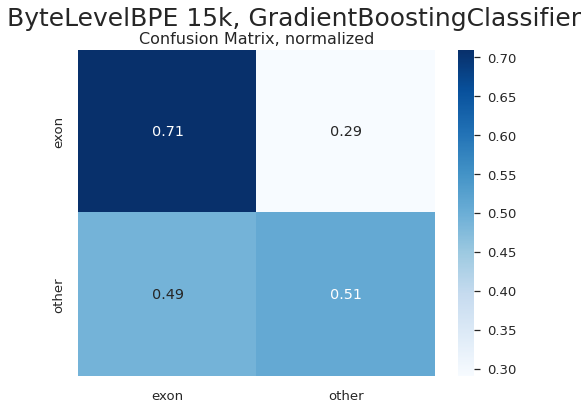

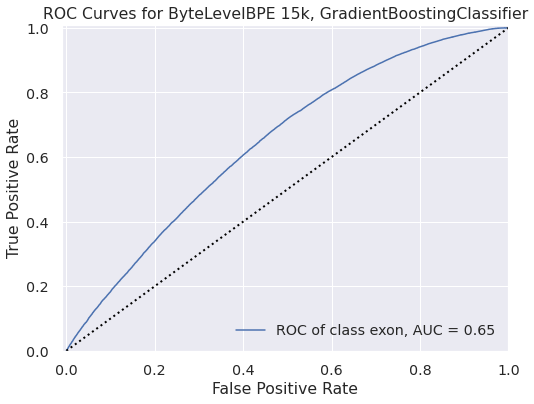

/home/lieberze/DP/Thesis/02_tokenizery_new_data/data/sample/Encoding/Encoded_512bp_1M_lines/NEW/ByteLevelBPE/All_512/50000
GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
test f1_score (weighted): 0.5863593329887968
              precision    recall  f1-score     support
exon           0.570795  0.761872  0.652635  24827.0000
other          0.649389  0.434990  0.520994  25173.0000
accuracy       0.597300  0.597300  0.597300      0.5973
macro avg      0.610092  0.598431  0.586815  50000.0000
weighted avg   0.610364  0.597300  0.586359  50000.0000


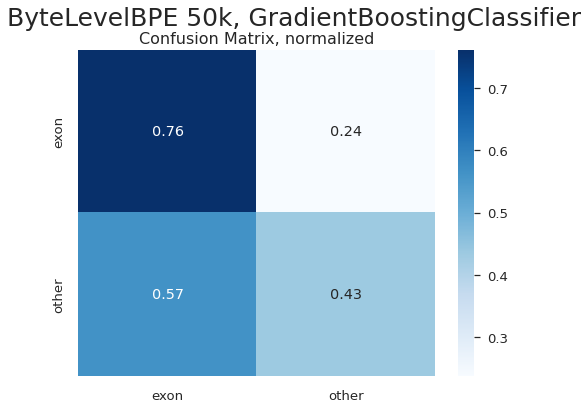

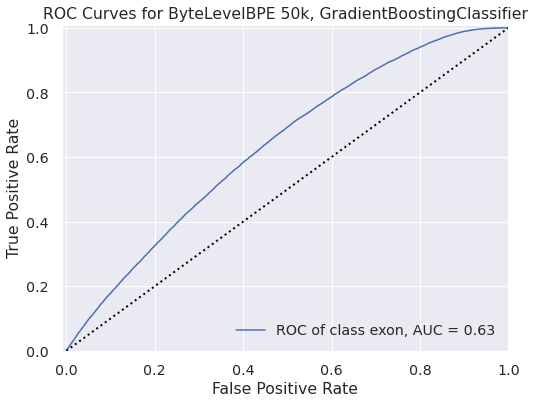

In [65]:
measures = []
if suffix == "2x2":
    subs = {
            "exon": "exon", 
            "intron": "other",
            "intergenic": "other"
            }
train_size = 150000
test_size = 50000
measures = []
for Path in Paths:
    algorithm, size = Path.split("/")[-3], Path.split("/")[-1]
    print(Path)
    X, y = LoadData(Path + f"/encoded_{suffix}.txt")
    if suffix == "2x2":
        y = [subs.get(item) for item in y]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = RANDOM_STATE)
    
    #smaller_sample
    X_tr, y_tr =  X_train[:train_size], y_train[:train_size]
    X_te, y_te = X_test[:test_size], y_test[:test_size]
    
    # load model
    model = joblib.load(Path + f"/classification_model_{suffix}.sav")
    print(model)
    
    ModelFolderName = str(model).split("(")[0] 
    
    size = str(int(size)/1000).split(".")[0]
    title = f"{algorithm} {size}k, {ModelFolderName}"
    
    sns.set(font_scale=1.2)  
    exon_vs_rest_f1_score_ = FitPredictGetMetrics(model, X_te, y_te, Path, title)
    measures.append(exon_vs_rest_f1_score_)
        
     # ROC AUC curve
    ROCAUCcurve(model, X_train, y_train, X_test, y_test, Path, title) 
    # break

## Save report as xlsx

In [59]:
reports = []
for Path in Paths:
    algorithm, size = Path.split("/")[-3], Path.split("/")[-1]
    # print(algorithm, size)
    df_report = pd.read_pickle(Path + f"/report_{suffix}.pkl")
    df_report["algorithm"] = algorithm
    df_report["vocab size"] = size
    reports.append(df_report)
dfs = [df for df in reports]
df = pd.concat(dfs, axis=0)
df.to_excel(f"{AttemptFolder}/reports_{suffix}.xlsx")

## Pick the best score (tokenizer)

In [ ]:
# # how to evaluate? look at the ratio (measures[2])?
# for p, m in zip(Paths, measures):
#     print(p)
#     print(m)

In [ ]:
# new_measures = []
# for p, m in zip(Paths, measures):
#     X = "-".join(p.split("/")[-3:])
#     new_measures.append([X, m])
# new_measures

In [ ]:
# measures
# zprumerovat do diplomky(?)
# vzit neco z 512 bp

In [ ]:
# sorted_by_third = sorted(new_measures, key=lambda tup: tup[1][2], reverse=True)
# sorted_by_third

## redo confusion matrices etc

In [ ]:
avgs = []
for Path in Paths:
    print(Path)
    filename = '/classification_model_2x2.sav'
    model = joblib.load(Path + filename)
        
# for model, grid in model_grid.items():
#     ModelFolderName = str(model).split("(")[0]    
#     # BestEstimator, Model = TryClassifier(model, grid, X_train, y_train)
    
#     # save files to:
#     Path = f"./{ResultsFolder}/{TokenizerAlgorithm}/{ModelFolderName}"
    
#     # create a folder if it doesn't already exist
#     !mkdir -p {Path}
    
#     # save best model
#     filename = f'/classification_model_{suffix}.sav'
#     joblib.dump(BestEstimator, Path + filename)
    
#     # save whole model with cv scores
#     with open(f"{Path}/ModelScores_{suffix}.pk", 'wb') as f:
#         pickle.dump(Model, f)
        
#     # results and confusion matrix
#     sns.set(font_scale=1.2)    
#     FitPredictGetMetrics(BestEstimator, X_test, y_test, Path, ModelFolderName)
    
#     # ROC AUC curve
#     if suffix == "3x3":
#         sns.set(font_scale=1.2)    
#         ROCAUCcurve(BestEstimator, X_train, y_train, X_test, y_test, Path) 

## Show saved results

In [ ]:
# !pip install pickle
import pickle as pkl
from PIL import Image

In [ ]:
Paths

In [ ]:
avgs = []
for Path in Paths:
    print(Path)
    with open(Path + '/report_2x2.pkl', 'rb') as f:
        report = pkl.load(f)
        
    # print(report)    
    w_a = report["f1-score"]["weighted avg"]
    print(report)
    avgs.append( [Path, w_a])
          
    conf_m = Image.open(Path + '/confusion_matrix_2x2.png')
    # roc = Image.open(Path + '/ROC_curve.png')
    
    conf_m.show()
    # roc.show() 

In [ ]:
avgs

# Encoding trial

In [ ]:
path = "/home/lieberze/DP/Thesis/tokenizery_new_data/01_CharBPE/All_genomes_sample/All_512/5000/"

from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained(path)

In [ ]:
FileToEncode_1M = "/home/lieberze/DP/Thesis/model_training/data/512_bp_for_encoding/NEW/2x2_200k_shuffled_train.txt"       

In [ ]:
with open(FileToEncode_1M, "r") as f:
    for i in f:
        print(i)
        break

In [ ]:
a = "ATCTGTATCCACAAAAGGCAAGGaggctgtatttttatttccatcctatgaatgaagaaattaaaattcaatggacactgaggctccttccacagtttggctactgtggacattgctgctatagacactggggtgcaggtgtcccagtgtttcactgcatccatatctttggggtaaatcctcagcagtgcaattgctgggtcgtaggacaggtctatttttaactctttgaggaacctccacatagttttccagagtggctgcaccaggtcaccttcccaccaacagtgcaggagggctcccctctctccacatcctctccaacatgtgtggtttcctgccttgttaatttcccccattctcactggggtgaggtgggatctcagtgtggttttgttttattttaagattttatttatttattcatgagacagagagagaaaatgagagagagagagagagagagaggcagagggagaagcaggctccatgcagggagccctacgtgggac"

In [ ]:
# tokenizer.tokenize(a, max_length=128, padding="max_length", truncation=True) 